#Imports and Environment

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import datetime
import json
import logging
import os
import sys
import time
from io import BytesIO
import functools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import xml.etree.ElementTree as ET


# Clone Google Github TPU directory and append paths to system
if not os.path.exists('tpu'):
  !git clone https://github.com/tensorflow/tpu/

sys.path.append('/content/tpu/models/official/efficientnet')
sys.path.append('/content/tpu/models/common')
sys.path.append('/content/tpu/tools/datasets')

# Import tf v1.15.0, enable eager execution, import tf v2 for summaries
%tensorflow_version 1.15
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
print("Running on Tensorflow v{}".format(tf.__version__))
import tensorflow.compat.v2 as tf2  # used for summaries only.
from tensorflow.core.protobuf import rewriter_config_pb2
from tensorflow.python.estimator import estimator


# Import files from cloned Efficientnet Github Reo
import imagenet_input
import efficientnet_builder
import utils
import preprocessing


# Import Google Cloud modules to access Google Cloud Storage Buckets
from google.cloud import storage
from oauth2client.service_account import ServiceAccountCredentials
import google.auth

# Install and import Google Cloud Storage File System
!pip install gcsfs
import gcsfs




Cloning into 'tpu'...
remote: Enumerating objects: 8096, done.
remote: Total 8096 (delta 0), reused 0 (delta 0), pack-reused 8096
Receiving objects: 100% (8096/8096), 23.73 MiB | 28.63 MiB/s, done.
Resolving deltas: 100% (5742/5742), done.
`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.15`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
Running on Tensorflow v1.15.2


Set Logging Level

In [2]:
# Log all events
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'  
logging.getLogger('tensorflow').setLevel(logging.INFO)
logging.disable(logging.NOTSET)
tf.get_logger().propagate = False


# Only log fatal errors
"""
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.ERROR)
logging.disable(logging.WARNING)
tf.get_logger().propagate = False
"""

"\nos.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL\nlogging.getLogger('tensorflow').setLevel(logging.ERROR)\nlogging.disable(logging.WARNING)\ntf.get_logger().propagate = False\n"

Connect to TPU

In [3]:
# Assert that notebook is connected to a TPU runtime
assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime'
TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
print('TPU address is', TPU_ADDRESS)

# Connect with TPU with Google Credentials
from google.colab import auth
auth.authenticate_user()
with tf.Session(TPU_ADDRESS) as session:
  print('TPU devices:')
  print(session.list_devices())

  # Upload credentials to TPU.
  with open('/content/adc.json', 'r') as f:
    auth_info = json.load(f)
  tf.contrib.cloud.configure_gcs(session, credentials=auth_info)
  # Now credentials are set for all future sessions on this TPU.

TPU address is grpc://10.23.233.42:8470
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 2248449642806210367), _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 4270907229786013589), _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 8153485020330419858), _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 15447884212847927902), _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 3073868523964751941), _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device

# Training Fully Connected Layer

###Parameters

In [0]:
model_name = "efficientnet-b0" #@param ["efficientnet-b0", "efficientnet-b5"] {type:"string"}
data_set = "dataset_tf_10000-100" #@param ["dataset-tf-XXL","dataset-validation","dataset-labeled", "dataset_tfrecords", "dataset_tf_10000-100", "cifar100", "dataset-tf-balanced", "dataset-filtered"] {type:"string"}

# run_name as a unique identifier to specify training run
run_name = "FT-28-01-20-8"

In [0]:
# Define model directory, where checkpoints are stored
model_dir = 'gs://ise-bucket/efficientnet/'+model_name+'/'+run_name


# Define, whether to run with pretrained weight, warm start or from scratch 
# Run with pretrained weights
init_checkpoint_dir = 'gs://ise-bucket/efficientnet/'+model_name+'/'

# Run with warm start fc head
#init_checkpoint_dir = 'gs://ise-bucket/efficientnet/'+model_name+'/FT-27-01-20-8/'

# Run on scratch
#init_checkpoint_dir = None


# Define further parameters
num_epochs = 200
log_step_count_steps = 64 #produce log every x steps
mixup_alpha = 0.0 
augment_name = None #whether to use randaugment - '"randaugment"
randaug_num_layers = 0 #value between 1-3 for randaugment
randaug_magnitude = 0 #value between 5-30 for randaugment
moving_average_decay = 0.9999
label_smoothing = 0.1
weight_decay = 1e-5
base_learning_rate = 0.016
lr_decay = True

In [0]:
# Model and dataset parameters depending on the selection above
model_params = {
    "efficientnet-b0":{"iterations_per_loop":100, "train_batch_size":1024},
    "efficientnet-b5":{"iterations_per_loop":128, "train_batch_size":1024}
                }

data_set_params = {
    "dataset_tfrecords":{"num_train_images":33021, "num_eval_images":8257, "num_label_classes":96,"data_dir":"gs://ise-bucket/efficientnet/dataset_tfrecords"},
    "dataset_tf_10000-100":{"num_train_images":169733, "num_eval_images":42434, "num_label_classes":100,"data_dir":'gs://ise-bucket/efficientnet/dataset-tf-20-01-13_1-img_10000-ent_100-class'},
    "cifar100":{"num_train_images":50000, "num_eval_images":10000, "num_label_classes":100,"data_dir":"gs://ise-bucket/cifar100"},
    "dataset-tf-balanced":{"num_train_images":159460, "num_eval_images":39866, "num_label_classes":100,"data_dir":'gs://ise-bucket/efficientnet/dataset-tf-20-01-15_1-img_2000-ent_100-class'},
    "dataset-filtered":{"num_train_images":156271, "num_eval_images":38173, "num_label_classes":100,"data_dir":'gs://ise-bucket/efficientnet/dataset-tf-20-01-29_1-img_2000-ent_100-class'},
    "dataset-labeled":{"num_train_images":0, "num_eval_images":74228, "num_label_classes":100,"data_dir":'gs://ise-bucket/efficientnet/dataset-tf-20-01-31_1-img_2000-ent_100-class_specific'},
    "dataset-validation":{"num_train_images":0, "num_eval_images":29162, "num_label_classes":100,"data_dir":'gs://ise-bucket/efficientnet/dataset-tf-20-02-01_1-img_2000-ent_100-class_specific'},
    "dataset-tf-XXL":{"num_train_images":683484, "num_eval_images":170871, "num_label_classes":100,"data_dir":'gs://ise-bucket/efficientnet/dataset-tf-20-01-22_1-img_10000-ent_100-class'}

}

model_params = model_params[model_name]
data_set_params = data_set_params[data_set]

# Automatically set parameters
data_dir = data_set_params["data_dir"]
iterations_per_loop = model_params["iterations_per_loop"]
num_train_images = data_set_params["num_train_images"]
num_eval_images =  data_set_params["num_eval_images"]
train_batch_size = model_params["train_batch_size"]
eval_batch_size = 1024
predict_batch_size = 64
train_steps = int(num_train_images / train_batch_size * num_epochs)
eval_steps = int(num_eval_images / eval_batch_size)
num_label_classes = data_set_params["num_label_classes"]
input_image_size = efficientnet_builder.efficientnet_params(model_name)[2] 

use_tpu = True
tpu_cluster_resolver = tf.contrib.cluster_resolver.TPUClusterResolver(TPU_ADDRESS)
skip_host_call = False
num_parallel_calls = 8
transpose_input=True
use_cache = True
include_background_label = False

###Function to get exponential moving average variables

In [0]:
def get_ema_vars():
  """Get all exponential moving average (ema) variables."""
  ema_vars = tf.trainable_variables() + tf.get_collection('moving_vars')
  for v in tf.global_variables():
    # We maintain mva for batch norm moving mean and variance as well.
    if 'moving_mean' in v.name or 'moving_variance' in v.name:
      ema_vars.append(v)
  return list(set(ema_vars))

###InputFn

In [0]:
def input_fn_builder(is_training):
  def input_fn(params):
      """Input function which provides a single batch for train or eval.
      Args:
        params: `dict` of parameters passed from the `TPUEstimator`.
            `params['batch_size']` is always provided and should be used as the
            effective batch size.
      Returns:
        A `tf.data.Dataset` object.
      """

      print(params)

      # Retrieves the batch size for the current shard. The # of shards is
      # computed according to the input pipeline deployment. See
      # tf.estimator.tpu.RunConfig for details.
      batch_size = params['batch_size'] #batch_size = train_batch_size / num_cores

      num_cores = 8
      imagenet_train = imagenet_input.ImageNetInput(
        is_training=is_training,
        data_dir=data_dir,
        transpose_input=transpose_input,
        cache=use_cache and is_training,
        image_size=input_image_size,
        num_parallel_calls=num_parallel_calls,
        use_bfloat16=False,
        num_label_classes=num_label_classes,
        include_background_label=include_background_label,
        augment_name=augment_name,
        mixup_alpha=mixup_alpha,
        randaug_num_layers=randaug_num_layers,
        randaug_magnitude=randaug_magnitude)

      if 'context' in params:
        current_host = params['context'].current_input_fn_deployment()[1]
        num_hosts = params['context'].num_hosts
      else:
        current_host = 0
        num_hosts = 1

      dataset = imagenet_train.make_source_dataset(current_host, num_hosts)
      
      # Use the fused map-and-batch operation.
      #
      # For XLA, we must used fixed shapes. Because we repeat the source training
      # dataset indefinitely, we can use `_remainder=True` to get fixed-size
      # batches without dropping any training examples.
      #
      # When evaluating, `drop_remainder=True` prevents accidentally evaluating
      # the same image twice by dropping the final batch if it is less than a full
      # batch size. As long as this validation is done with consistent batch size,
      # exactly the same images will be used.

      dataset = dataset.apply(
          tf.data.experimental.map_and_batch(
              imagenet_train.dataset_parser, batch_size=batch_size,
              num_parallel_batches=num_cores, drop_remainder=True))
      
      # Apply Mixup
      if imagenet_train.is_training and imagenet_train.mixup_alpha > 0.0:
        dataset = dataset.map(
            functools.partial(imagenet_train.mixup, batch_size, imagenet_train.mixup_alpha),
            num_parallel_calls=num_cores)

      
      # Transpose for performance on TPU
      if imagenet_train.transpose_input:
        dataset = dataset.map(
            lambda images, labels: (tf.transpose(images, [1, 2, 3, 0]), labels),
            num_parallel_calls=num_cores)

      # Assign static batch size dimension
      dataset = dataset.map(functools.partial(imagenet_train.set_shapes, batch_size))
      

      # Prefetch overlaps in-feed with training
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      
      return dataset
  return input_fn

In [0]:
def input_fn_builder_unshuffled(is_training, only_filenames=False):
  def input_fn(params):
      """Input function which provides data withouth shuffling for evaluation.
      Args:
        params: `dict` of parameters passed from the `TPUEstimator`.
            `params['batch_size']` is always provided and should be used as the
            effective batch size.
      Returns:
        A `tf.data.Dataset` object.
      """

      num_cores = 8
    
      if 'context' in params:
        current_host = params['context'].current_input_fn_deployment()[1]
        num_hosts = params['context'].num_hosts
      else:
        current_host = 0
        num_hosts = 1

      if "batch_size" in params:
        batch_size = params['batch_size']
          
      file_pattern = os.path.join(
          data_dir, 'train-*' if is_training else 'validation-*')

      dataset = tf.data.Dataset.list_files(file_pattern, shuffle=False)
      dataset = dataset.shard(num_hosts, current_host)

      def fetch_dataset(filename):
        buffer_size = 8 * 1024 * 1024  # 8 MiB per file
        dataset = tf.data.TFRecordDataset(filename, buffer_size=buffer_size)
        return dataset

      # Read the data from disk in parallel
      dataset = dataset.apply(
          tf.data.experimental.parallel_interleave(
              fetch_dataset, cycle_length=num_parallel_calls, sloppy=False))

      
      def custom_dataset_parser(value):
        keys_to_features = {
            'image/encoded': tf.FixedLenFeature((), tf.string, ''),
            'image/class/label': tf.FixedLenFeature([], tf.int64, -1),
            'image/filename': tf.FixedLenFeature([], tf.string, ''),
            'image/class/text': tf.FixedLenFeature([], tf.string, '')
        }

        parsed = tf.parse_single_example(value, keys_to_features)
        
        image_bytes = tf.reshape(parsed['image/encoded'], shape=[])

        
        image = preprocessing.preprocess_image(
            image_bytes=image_bytes,
            is_training=is_training,
            image_size=input_image_size,
            use_bfloat16=False,
            augment_name=augment_name,
            randaug_num_layers=randaug_num_layers,
            randaug_magnitude=randaug_magnitude)
        
              
        label = tf.cast(tf.reshape(parsed['image/class/label'], shape=[]), dtype=tf.int32)
        onehot_label = tf.one_hot(label, num_label_classes)

        label_text = parsed['image/class/text']
        file_name = parsed['image/filename']

        if only_filenames:
          return label_text, file_name
        return image, onehot_label

      dataset = dataset.apply(
          tf.data.experimental.map_and_batch(
              custom_dataset_parser, batch_size=batch_size,
              num_parallel_batches=num_cores, drop_remainder=False))

      # Prefetch overlaps in-feed with training
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      
      return dataset
  return input_fn

###ModelFn

In [0]:
def model_fn(features, labels, mode, params):
  """The model_fn to be used with TPUEstimator.
  Args:
    features: `Tensor` of batched images.
    labels: `Tensor` of one hot labels for the data samples
    mode: one of `tf.estimator.ModeKeys.{TRAIN,EVAL,PREDICT}`
    params: `dict` of parameters passed to the model from the TPUEstimator,
        `params['batch_size']` is always provided and should be used as the
        effective batch size.
  Returns:
    A `TPUEstimatorSpec` for the model
  """
  if isinstance(features, dict):
    print("is dict")
    features = features['feature']

  stats_shape = [1, 1, 3]

  if transpose_input and mode != tf.estimator.ModeKeys.PREDICT:
    features = tf.transpose(features, [3, 0, 1, 2])  # HWCN to NHWC

  is_training = (mode == tf.estimator.ModeKeys.TRAIN)
  has_moving_average_decay = (moving_average_decay > 0)

  # This is essential, if using a keras-derived model.
  tf.keras.backend.set_learning_phase(is_training)
  tf.logging.info('Using open-source implementation.')
  override_params = {}

  def normalize_features(features, mean_rgb, stddev_rgb):
    """Normalize the image given the means and stddevs."""
    features -= tf.constant(mean_rgb, shape=stats_shape, dtype=features.dtype)
    features /= tf.constant(stddev_rgb, shape=stats_shape, dtype=features.dtype)
    return features

  def build_model():
    """Build model using the model_name given through the command line."""
    model_builder = efficientnet_builder
    normalized_features = normalize_features(features, model_builder.MEAN_RGB,
                                             model_builder.STDDEV_RGB)
    
    output_layer, endpoints = model_builder.build_model(
        normalized_features,
        model_name=model_name,
        fine_tuning = True,
        pooled_features_only = False,
        features_only = False,
        training=is_training,
        override_params=override_params,
        model_dir=model_dir)

      
    # Connect a new Dense Layer to the global pooling features of the pretrained CNN
    def dense_kernel_initializer(shape, dtype=None, partition_info=None):
      del partition_info
      init_range = 1.0 / np.sqrt(shape[1])
      return tf.random_uniform(shape, -init_range, init_range, dtype=dtype)

    _fc = tf.layers.Dense(
            num_label_classes,
            kernel_initializer=dense_kernel_initializer,name = "ldense")
      
    logits = _fc(endpoints['global_pool']) #connect to global pooling layer of pretrained CNN (other endpoints possible)
    

    return logits

  logits = build_model()

  train_op = None
  host_call = None




  # PREDICTION MODE
  # ******************************************************************************
  if mode == tf.estimator.ModeKeys.PREDICT:
    predictions = {
        'label': tf.argmax(labels, axis=1),
        'prediction': tf.argmax(logits, axis=1),
        'probabilities': tf.nn.softmax(logits, name='softmax_tensor')
    }
    return tf.estimator.tpu.TPUEstimatorSpec(
        mode=mode,
        predictions=predictions,
        export_outputs={
            'classify': tf.estimator.export.PredictOutput(predictions)
        })




  # CONTINUE WITH TRAINING OR EVAL MODE
  # ******************************************************************************
  batch_size = params['batch_size']

  # Calculate loss, which includes softmax cross entropy and L2 regularization.
  cross_entropy = tf.losses.softmax_cross_entropy(
      logits=logits,
      onehot_labels=labels,
      label_smoothing=label_smoothing)

  # Add weight decay to the loss for non-batch-normalization variables.
  loss = cross_entropy + weight_decay * tf.add_n(
      [tf.nn.l2_loss(v) for v in tf.trainable_variables()
       if 'batch_normalization' not in v.name])

  global_step = tf.train.get_global_step()
  tf.logging.info("globalstep:{}".format(global_step))

  restore_vars_dict = None
  if has_moving_average_decay:
    ema = tf.train.ExponentialMovingAverage(decay=moving_average_decay, num_updates=global_step)
    ema_vars = get_ema_vars()
    restore_vars_dict = ema.variables_to_restore(ema_vars)
  
  # TRAINING MODE
  # ******************************************************************************
  if is_training:
    # Compute the current epoch and associated learning rate from global_step.
    current_epoch = (tf.cast(global_step, tf.float32) / params['steps_per_epoch'])
    tf.logging.info('current epoch = {}'.format(tf.reshape(current_epoch, [1])))
    
    scaled_lr = base_learning_rate * (train_batch_size / 256.0)
    tf.logging.info('base_learning_rate = %f', base_learning_rate)
    learning_rate = utils.build_learning_rate(scaled_lr, global_step,params['steps_per_epoch'])
    
    # Override scaled learning rate with base_learning_rate (comment if scaled lr decay be used)
    if not lr_decay:
      learning_rate = scaled_lr
    
    optimizer = utils.build_optimizer(learning_rate)
    print("learning rate:",learning_rate)

    optimizer = tf.tpu.CrossShardOptimizer(optimizer)

    # Batch normalization requires UPDATE_OPS to be added as a dependency to
    # the train operation.
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    
    vars_to_update = [var for var in tf.trainable_variables() if 'ldense' in var.name]
    print(vars_to_update)
    
    with tf.control_dependencies(update_ops):
      train_op = optimizer.minimize(loss, global_step, var_list=vars_to_update)


    if has_moving_average_decay:
      with tf.control_dependencies([train_op]):
        train_op = ema.apply(ema_vars)


    # Host Call Function to write scalar summaries for Tensorboard
    def host_call_fn(gs, lr, ce,acc):
      print("host call")
      gs = gs[0]

      with tf2.summary.create_file_writer(model_dir, max_queue=iterations_per_loop).as_default():
        with tf2.summary.record_if(True):
          tf2.summary.scalar('learning_rate', lr[0], step=gs)
          tf2.summary.scalar('current_epoch', ce[0], step=gs)
          tf2.summary.scalar('accuracy', acc[0], step=gs)
        return tf.summary.all_v2_summary_ops()

    gs_t = tf.reshape(global_step, [1])
    lr_t = tf.reshape(learning_rate, [1])
    ce_t = tf.reshape(current_epoch, [1])

    labels = tf.argmax(labels, axis=1)
    predictions = tf.argmax(logits, axis=1)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(predictions, labels), tf.float32)) # own accuracy metric
    accuracy_t = tf.reshape(accuracy, [-1])

    host_call = (host_call_fn, [gs_t, lr_t, ce_t,accuracy_t])


    if init_checkpoint_dir:

      num_params = np.sum([np.prod(v.shape) for v in tf.trainable_variables()])
      tf.logging.info('number of trainable parameters: %d', num_params)

      # TPU Scaffold Function to load variables from initial pretrained checkpoint 
      def tpu_scaffold():
        print("init_checkpoint_dir: {}".format(init_checkpoint_dir))

        # Remove variables that are not stored in pretrained checkpoint
        restore_vars_dict.pop("global_step")
        #restore_vars_dict.pop("output_bias/ExponentialMovingAverage")
        #restore_vars_dict.pop("output_weights/ExponentialMovingAverage")
        restore_vars_dict.pop("ldense/bias/ExponentialMovingAverage")
        restore_vars_dict.pop("ldense/kernel/ExponentialMovingAverage")
        tf.train.init_from_checkpoint(init_checkpoint_dir, restore_vars_dict)
        print("init checkpoint finished")
        return tf.train.Scaffold()

      scaffold_fn = tpu_scaffold

      return tf.estimator.tpu.TPUEstimatorSpec(
        mode=mode,
        loss=loss,
        train_op=train_op,
        host_call=host_call,
        scaffold_fn=scaffold_fn
        )
      
    return tf.estimator.tpu.TPUEstimatorSpec(
      mode=mode,
      loss=loss,
      train_op=train_op,
      host_call=host_call
      )





  # EVALUATION MODE
  # ******************************************************************************
  if mode == tf.estimator.ModeKeys.EVAL:

    # Function to compute confusion matrix with labels and predictions
    def eval_confusion_matrix(labels, predictions):
        with tf.variable_scope("eval_confusion_matrix"):
          con_matrix = tf.confusion_matrix(labels=labels, predictions=predictions, num_classes=num_label_classes)

          con_matrix_sum = tf.Variable(lambda: tf.zeros(shape=(num_label_classes,num_label_classes), dtype=tf.int32),
                                              trainable=False,
                                              name="confusion_matrix_result",
                                              collections=[tf.GraphKeys.LOCAL_VARIABLES])


          update_op = tf.assign_add(con_matrix_sum, con_matrix)

          return tf.convert_to_tensor(con_matrix_sum), update_op

    # Metric Function to return and write evaluation metrics 
    def metric_fn(labels, logits):
      """Evaluation metric function. Evaluates accuracy.
      This function is executed on the CPU and should not directly reference
      any Tensors in the rest of the `model_fn`. To pass Tensors from the model
      to the `metric_fn`, provide as part of the `eval_metrics`. See
      https://www.tensorflow.org/api_docs/python/tf/estimator/tpu/TPUEstimatorSpec
      for more information.
      Arguments should match the list of `Tensor` objects passed as the second
      element in the tuple passed to `eval_metrics`.
      Args:
        labels: `Tensor` with shape `[batch, num_classes]`.
        logits: `Tensor` with shape `[batch, num_classes]`.
      Returns:
        A dict of the metrics to return from evaluation.
      """
      labels = tf.argmax(labels, axis=1)
      predictions = tf.argmax(logits, axis=1)

      top_1_accuracy = tf.metrics.accuracy(labels, predictions)
      in_top_5 = tf.cast(tf.nn.in_top_k(logits, labels, 5), tf.float32)
      top_5_accuracy = tf.metrics.mean(in_top_5)
      con_mat= eval_confusion_matrix(labels, predictions)

      return {
          'top_1_accuracy': top_1_accuracy,
          'top_5_accuracy': top_5_accuracy,
          'con_mat':con_mat
      }

    eval_metrics = (metric_fn, [labels, logits])

    return tf.estimator.tpu.TPUEstimatorSpec(
      mode=mode,
      loss=loss,
      eval_metrics=eval_metrics,
    )

###Run Config and Estimator

In [11]:
# Set up Run Configuration and Estimator
params = dict(
      steps_per_epoch=num_train_images / train_batch_size,
      use_bfloat16=False);

save_checkpoints_steps = 2*params["steps_per_epoch"];

config = tf.estimator.tpu.RunConfig(
      cluster=tpu_cluster_resolver,
      model_dir=model_dir, #model dir used for 
      save_checkpoints_steps=save_checkpoints_steps,
      keep_checkpoint_max = 100,
      log_step_count_steps=log_step_count_steps,
      session_config=tf.ConfigProto(
          graph_options=tf.GraphOptions(
              rewrite_options=rewriter_config_pb2.RewriterConfig(
                  disable_meta_optimizer=True))),
      tpu_config=tf.estimator.tpu.TPUConfig(
          iterations_per_loop=iterations_per_loop,
          per_host_input_for_training=tf.estimator.tpu.InputPipelineConfig
          .PER_HOST_V2));

est = tf.estimator.tpu.TPUEstimator(
      use_tpu=use_tpu,
      model_fn=model_fn,
      config=config,
      train_batch_size=train_batch_size,
      eval_batch_size=eval_batch_size,
      predict_batch_size = predict_batch_size,
      params=params);

INFO:tensorflow:Using config: {'_model_dir': 'gs://ise-bucket/efficientnet/efficientnet-b0/FT-28-01-20-8', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 331.509765625, '_save_checkpoints_secs': None, '_session_config': graph_options {
  rewrite_options {
    disable_meta_optimizer: true
  }
}
cluster_def {
  job {
    name: "worker"
    tasks {
      key: 0
      value: "10.23.233.42:8470"
    }
  }
}
, '_keep_checkpoint_max': 100, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f6d81269940>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': 'grpc://10.23.233.42:8470', '_evaluation_master': 'grpc:

### Train

In [0]:
def training(epochs):
  start_timestamp = datetime.datetime.now() # This time will include compilation time
  tf.logging.info("*"*100)
  tf.logging.info("Start training for {} epochs at {}".format(epochs, start_timestamp))
  current_step = estimator._load_global_step_from_checkpoint_dir(model_dir)
  steps_this_run = np.min([epochs*params['steps_per_epoch'],train_steps-current_step]) # runs for epochs minimum per run and maximum to train_steps
  tf.logging.info(
      'Training for %d steps (%.2f epochs in total). Current'
      ' step %d.', steps_this_run,
      steps_this_run / params['steps_per_epoch'], current_step)
  tf.contrib.summary.always_record_summaries()
  est.train(
      input_fn=input_fn_builder(is_training=True),
      max_steps=int(current_step+steps_this_run))

  end_timestamp = datetime.datetime.now() # This time will include compilation time
  tf.logging.info("Finished training at {}".format(end_timestamp))
  tf.logging.info("*"*100)

In [0]:
training(50)

###Evaluation

In [0]:
def evaluation(checkpoint_path):
  start_timestamp = datetime.datetime.now() # This time will include compilation time
  tf.logging.info("*"*100)
  current_step = estimator._load_global_step_from_checkpoint_dir(model_dir)
  epoch = current_step / params['steps_per_epoch']
  tf.logging.info("Start evaluation epoch {} at {}".format(epoch,start_timestamp))
  predictions = est.evaluate(input_fn = input_fn_builder(is_training=False), steps = eval_steps, checkpoint_path=checkpoint_path)
  end_timestamp = datetime.datetime.now() # This time will include compilation time
  tf.logging.info("Finished evaluation at {}".format(end_timestamp))
  tf.logging.info("*"*100)
  return predictions

In [0]:
checkpoints_evaluated = 0
import gcsfs
fs = gcsfs.GCSFileSystem()
fs.invalidate_cache(model_dir)

df_eval = pd.read_csv(model_dir+"/checkpoint",header=None)
ckpt_list = [ckpt.split(": ")[1].replace('"','') for ckpt in df_eval[0].values[1:]]
for ckpt in ckpt_list[74:75]:
    checkpoint_path = model_dir+"/"+ckpt
    print(checkpoint_path)
    eval_out = evaluation(checkpoint_path)
    #checkpoints_evaluated += 1

# Clean Datasets

In [0]:
# Define the checkpoint_path used for prediction and the difference between the highest confidence and the ground truth confidence as a rejection criterion
checkpoint_path = model_dir+"/model.ckpt-9000"
difference_max_conf_to_gt_conf = 0.3

In [0]:
# Define checkpoint_path and predict rdf:type of images
print("predict with checkpoint:",checkpoint_path)
predictions = est.predict(input_fn=input_fn_builder_unshuffled(is_training=False),yield_single_examples=True, checkpoint_path=checkpoint_path)
prediction_output = list(predictions)

In [0]:
# Return filename of images that are predicted
data = input_fn_builder_unshuffled(is_training=False, only_filenames=True)(params)
labels_and_filenames = []

for elem in data:
  labels_and_filenames.append(elem)

file_names = [x[1].numpy()[0].decode("utf-8") for x in labels_and_filenames]

# Zip file names and predictions
zipped_data = list(zip(file_names,prediction_output))

In [0]:
# Denoise dataset by images that are probably mislabeled
remaining_files = []
count = 0
for x in zipped_data:
  file_name = x[0]
  label = x[2]["label"]-1
  prediction = x[2]["prediction"]
  if label != prediction:
    max_conf = np.max(x[2]["probabilities"])
    gt_conf = x[2]["probabilities"][label]
    prediction_is_likely = True if max_conf-gt_conf > 0.3 else False
    if prediction_is_likely:
      count += 1
    else:
      remaining_files.append(("gs://ise-bucket/efficientnet/dataset-20-01-13_1-img_10000-ent_100-class/"+file_name,inverse_label_map[label]))
  else:
    remaining_files.append(("gs://ise-bucket/efficientnet/dataset-20-01-13_1-img_10000-ent_100-class/"+file_name,inverse_label_map[label]))

print(count)
print(len(remaining_files))
print(count/len(zipped_data))
df_remaining_files = pd.DataFrame(remaining_files,columns=["url","label"])
df_remaining_files.to_csv("filtered_training_path_label.csv")
print(df_remaining_files.head(5))

#Evaluation with hierarchy approach

###functions to get predictions and ground truth labels for images

In [0]:
def predict_with_ckpt_for_ckpt_number(_model_name, _run_name, _ckpt_num):
  _model_dir = 'gs://ise-bucket/efficientnet/'+_model_name+'/'+_run_name
  checkpoint_path = _model_dir+"/model.ckpt-"+_ckpt_num
  print("predict with checkpoint:",checkpoint_path)

  params = dict(
      steps_per_epoch=num_train_images / train_batch_size,
      use_bfloat16=False);

  save_checkpoints_steps = params["steps_per_epoch"];

  config = tf.estimator.tpu.RunConfig(
        cluster=tpu_cluster_resolver,
        model_dir=_model_dir, 
        save_checkpoints_steps=save_checkpoints_steps,
        keep_checkpoint_max = 100,
        log_step_count_steps=log_step_count_steps,
        session_config=tf.ConfigProto(
            graph_options=tf.GraphOptions(
                rewrite_options=rewriter_config_pb2.RewriterConfig(
                    disable_meta_optimizer=True))),
        tpu_config=tf.estimator.tpu.TPUConfig(
            iterations_per_loop=iterations_per_loop,
            per_host_input_for_training=tf.estimator.tpu.InputPipelineConfig
            .PER_HOST_V2));

  est = tf.estimator.tpu.TPUEstimator(
        use_tpu=use_tpu,
        model_fn=model_fn,
        config=config,
        train_batch_size=train_batch_size,
        eval_batch_size=eval_batch_size,
        predict_batch_size = predict_batch_size,
        params=params);


  predictions = est.predict(input_fn=input_fn_builder_unshuffled(is_training=False),yield_single_examples=True, checkpoint_path=checkpoint_path)
  prediction_output = list(predictions)
  return prediction_output

In [0]:
def get_filenames_for_images():
  params = {"batch_size":1}
  data = input_fn_builder_unshuffled(is_training=False, only_filenames=True)(params)

  filenames = []
  idx = 0
  for elem in data:
    idx += 1
    if idx % 10000 == 0:
      print(idx)
    filename = elem[1].numpy()[0].decode("utf-8")
    filenames.append(filename)
  return filenames

In [0]:
def get_labels_for_images():
  fs = gcsfs.GCSFileSystem()
  fs.invalidate_cache('gs://ise-bucket/efficientnet/configs/config_9/labels.csv')  
  if tf.gfile.Exists('gs://ise-bucket/efficientnet/configs/config_9/labels.csv'):
    print("load labels.csv")
    labels_df = pd.read_csv('gs://ise-bucket/efficientnet/configs/config_9/labels.csv',header=None)
    labels = labels_df[0].values.tolist()
  else:
    store_labels_for_images()
    labels = get_labels_for_images()
  return labels

In [0]:
def store_labels_for_images():
  print("store labels.csv")
  df_labels = pd.read_csv("gs://ise-bucket/efficientnet/configs/config_9/validation_path_label.csv")
  filenames_csv = df_labels["Input"].values.tolist()
  labels_csv = df_labels["Output"].values.tolist()
  filename_to_label_dict = {x[0].split("/")[-1]:x[1] for x in list(zip(filenames_csv,labels_csv))}

  filenames = get_filenames_for_images()

  labels = [filename_to_label_dict[filename] for filename in filenames]

  labels_df = pd.DataFrame(labels,columns=["label"])
  labels_df.to_csv("gs://ise-bucket/efficientnet/configs/config_9/labels.csv", index=False, header=False)

##functions to store predictions and ground truth labels

In [0]:
def store_predictions_to_csv(prediction_output):
  list_of_probs = []
  list_of_labels = []

  for image in prediction_output:
    list_of_probs.append(image["probabilities"])
    list_of_labels.append(image["label"])

  pd.DataFrame(list_of_probs).to_csv("confidences.csv")
  pd.DataFrame(list_of_labels).to_csv("labels.csv")

## create datastructures for metric calculation

In [17]:
df = pd.read_csv('gs://ise-bucket/efficientnet/hierarchy_lists/dbo classes hierarchies.csv',index_col=None)
hierarchies_raw = df.values.tolist()
hierarchies = [[i for i in line if type(i) != float] for line in hierarchies_raw]
hierarchies = [[i for i in line if i != "owl:Thing"] for line in hierarchies]
hierarchy_list = hierarchies[:-10]


all_labels = []
all_labels_index = []
all_labels_to_index = {}
for idx, hierarchy in enumerate(hierarchy_list):
  leaf_node_of_hierarchy = hierarchy[-1]
  all_labels.append(leaf_node_of_hierarchy)
  all_labels_index.append(idx)
  all_labels_to_index[leaf_node_of_hierarchy] = idx

print(all_labels)
print(all_labels_index)
print(all_labels_to_index)
print()


df = pd.read_csv('gs://ise-bucket/efficientnet/configs/config_3/labels_map.csv',index_col=None)
labels_map = dict(zip(df.label, df.label_index))
labels_map_reverse = dict(zip(df.label_index, df.label))
labels_map_index = {all_labels_to_index[k]:v for k,v in labels_map.items()}
labels_map_index_reverse = {v:all_labels_to_index[k] for k,v in labels_map.items()}
print(labels_map)
print(labels_map_reverse)
print(labels_map_index)
print(labels_map_index_reverse)
print()


labels_with_predictions = list(labels_map.keys())
labels_with_predictions_index = [all_labels_to_index[label] for label in labels_with_predictions]
print(labels_with_predictions)
print(labels_with_predictions_index)
print()



hierarchy_dict = {}
hierarchy_dict_index = {}
for idx, hierarchy in enumerate(hierarchy_list):
  leaf_node_of_hierarchy = hierarchy[-1]
  hierarchy_dict[leaf_node_of_hierarchy] = hierarchy

  leaf_node_idx = all_labels_to_index[leaf_node_of_hierarchy]
  hierarchy_idxs = [all_labels_to_index[elem] for elem in hierarchy]
  hierarchy_dict_index[leaf_node_idx] = hierarchy_idxs

print(hierarchy_dict)
print(hierarchy_dict_index)
print()



labels_per_level = {1:[],2:[],3:[],4:[],5:[],6:[],7:[]}
labels_per_level_index = {1:[],2:[],3:[],4:[],5:[],6:[],7:[]}
for idx, hierarchy in enumerate(hierarchy_list):
  level = len(hierarchy)
  leaf_node_of_hierarchy = hierarchy[-1]
  labels_per_level[level].append(leaf_node_of_hierarchy)
  leaf_node_idx = all_labels_to_index[leaf_node_of_hierarchy]
  labels_per_level_index[level].append(leaf_node_idx)

print(labels_per_level)
print(labels_per_level_index)
print()



child_parent_dict = {}
child_parent_dict_index = {}
for idx, hierarchy in enumerate(hierarchy_list):
  if len(hierarchy)>1:
    child = hierarchy[-1]
    child_idx = all_labels_to_index[child]
    parent = hierarchy[-2]
    parent_idx = all_labels_to_index[parent]
    child_parent_dict[child] = parent
    child_parent_dict_index[child_idx] = parent_idx

print(child_parent_dict)
print(child_parent_dict_index)
print()

inverse_label_map = {value-1:key for key,value in labels_map.items()}

lvl1_label_to_index = {label:index for index,label in enumerate(labels_per_level[1])}
print(lvl1_label_to_index)
print()

level_of_label_index = {v[-1]:len(v) for k,v in hierarchy_dict_index.items()}
print(level_of_label_index)

['Activity', 'Game', 'BoardGame', 'CardGame', 'Sales', 'Sport', 'Athletics', 'TeamSport', 'Agent', 'Deity', 'Employer', 'Family', 'NobleFamily', 'FictionalCharacter', 'ComicsCharacter', 'AnimangaCharacter', 'DisneyCharacter', 'MythologicalFigure', 'NarutoCharacter', 'SoapCharacter', 'Organisation', 'Broadcaster', 'BroadcastNetwork', 'RadioStation', 'TelevisionStation', 'Company', 'Bank', 'Brewery', 'Caterer', 'LawFirm', 'PublicTransitSystem', 'Airline', 'BusCompany', 'Publisher', 'RecordLabel', 'Winery', 'EducationalInstitution', 'College', 'Library', 'School', 'University', 'EmployersOrganisation', 'GeopoliticalOrganisation', 'GovernmentAgency', 'GovernmentCabinet', 'Group', 'Band', 'ComedyGroup', 'InternationalOrganisation', 'Legislature', 'MilitaryUnit', 'Non-ProfitOrganisation', 'RecordOffice', 'Parliament', 'PoliticalParty', 'ReligiousOrganisation', 'ClericalOrder', 'SambaSchool', 'SportsClub', 'HockeyClub', 'RugbyClub', 'SoccerClub', 'NationalSoccerClub', 'SportsLeague', 'America

## functions to calculate metrics

In [0]:
# Calculate aggregated confidences basend on the class hierarchy
def calc_agg_confs(_prediction_output):
  agg_conf_per_image_dict = {}
  top_pred_per_level_per_image = {}

  levels_desc = list(labels_per_level.keys())
  levels_desc.sort(reverse=True)

  for ent_index,ent in enumerate(_prediction_output): #for each image
    if ent_index % 10000 == 0:
      print(ent_index)

    top_pred_per_level = {}

    label_conf = {label_idx:0 for label_idx in all_labels_index} # initialize confidences for each label with 0

    for level in levels_desc: #for each level (in descending order 7 -> 1)
      label_idxs = labels_per_level_index[level]

      level_top_pred_conf = 0
      level_top_pred_idx = 0

      for label_idx in label_idxs:
          if label_idx in labels_with_predictions_index: #update own value
            index = labels_map_index[label_idx]-1
            label_conf[label_idx] += ent["probabilities"][index]
            
          if label_idx in child_parent_dict_index.keys(): #update parent value
            parent_label_idx = child_parent_dict_index[label_idx]
            label_conf[parent_label_idx] += label_conf[label_idx]

          if label_conf[label_idx] > level_top_pred_conf: #if it is highest prediction, then update
            level_top_pred_conf = label_conf[label_idx]
            level_top_pred_idx = label_idx
      
      top_pred_per_level[level] = (level_top_pred_idx,level_top_pred_conf)

    agg_conf_per_image_dict[ent_index] = label_conf
    top_pred_per_level_per_image[ent_index] = top_pred_per_level
  
  return agg_conf_per_image_dict,top_pred_per_level_per_image

In [0]:
# Predict with lowest possible level (most finegrained) that is above a certain confidence threshold
def calc_acc_lowest_level_above_threshold(_prediction_output, _top_pred_per_level_per_image, labels):
  accs_lvl_all = []
  rel_data_lvl_all = []
  avg_lvl_all = []

  levels_desc = list(labels_per_level.keys())
  levels_desc.sort(reverse=True)

  for conf_threshold in range(0,100,5):  
      conf_threshold = conf_threshold/100
      scores_lvl_all = 0
      tries = 0
      levels_of_pred = []

      for ent_index,ent in enumerate(_prediction_output):
          gt_label = labels[ent_index]
          gt_idx = all_labels_to_index[gt_label]
          #gt_idx = labels_map_index_reverse[ent["label"]]
          gt_hierarchy_idxs = hierarchy_dict_index[gt_idx]
          
          for level in levels_desc:
              top_pred = _top_pred_per_level_per_image[ent_index][level]
              top_pred_conf = top_pred[1]

              if top_pred_conf >= conf_threshold:
                  tries += 1
                  top_pred_idx = top_pred[0]

                  if top_pred_idx in gt_hierarchy_idxs:
                      scores_lvl_all += 1
                      levels_of_pred.append(level)
                  break;

      acc = scores_lvl_all/tries if tries > 0 else 0
      #print("threshold: %.2f \tacc: %.2f \t%% of data predicted: %.2f \tavg predicted level: %.2f" % (conf_threshold, acc, tries/len(_prediction_output), np.mean(levels_of_pred)))
      accs_lvl_all.append(acc)
      rel_data_lvl_all.append(tries/len(_prediction_output))
      avg_lvl_all.append(np.mean(levels_of_pred))
  return accs_lvl_all,rel_data_lvl_all,avg_lvl_all

In [0]:
# Predict always with one level above original prediction 
def calc_acc_one_level_up(_prediction_output, _agg_conf_per_image_dict, labels):
  accs_lvl1 = []
  rel_data_lvl1 = []
  avg_lvl1 = []

  for conf_threshold in range(0,100,5):  
      conf_threshold = conf_threshold/100
      scores_lvl1 = 0
      tries = 0
      levels = []

      for ent_index,ent in enumerate(_prediction_output):
          gt_label = labels[ent_index]
          gt_idx = all_labels_to_index[gt_label]
          gt_hierarchy_idxs = hierarchy_dict_index[gt_idx]

          pred_idx = labels_map_index_reverse[ent["prediction"]+1]
          pred_hierarchy_idxs = hierarchy_dict_index[pred_idx]

          if pred_idx in child_parent_dict_index.keys(): 
            pred_idx = child_parent_dict_index[pred_idx]
          
          pred_conf = agg_conf_per_image_dict[ent_index][pred_idx]

          if pred_conf >= conf_threshold:
              tries += 1
              if pred_idx in gt_hierarchy_idxs:
                  scores_lvl1 += 1
                  levels.append(level_of_label_index[pred_idx])
                  
      acc = scores_lvl1/tries if tries > 0 else 0
      #print("threshold: %.2f \tacc: %.2f \t%% of data predicted: %.2f \tavg predicted level: %.2f" % (conf_threshold, acc, tries/len(_prediction_output), np.mean(levels)))
      accs_lvl1.append(acc)
      rel_data_lvl1.append(tries/len(_prediction_output))
      avg_lvl1.append(np.mean(levels))
  return accs_lvl1, rel_data_lvl1, avg_lvl1

In [0]:
# Predict with lowest possible level of the hierarchy of the original prediction
def calc_acc_one_level_up_if_below_threshold(_prediction_output, _agg_conf_per_image_dict, labels):
  accs_lvl1 = []
  rel_data_lvl1 = []
  avg_lvl1 = []

  for conf_threshold in range(0,100,5):  
      conf_threshold = conf_threshold/100
      scores_lvl1 = 0
      tries = 0
      levels = []

      for ent_index,ent in enumerate(_prediction_output):
          gt_label = labels[ent_index]
          gt_idx = all_labels_to_index[gt_label]
          gt_hierarchy_idxs = hierarchy_dict_index[gt_idx]

          pred_idx = labels_map_index_reverse[ent["prediction"]+1]
          pred_hierarchy_idxs = hierarchy_dict_index[pred_idx]

          pred_conf = agg_conf_per_image_dict[ent_index][pred_idx]

          while pred_conf < conf_threshold:
            if pred_idx in child_parent_dict_index.keys(): 
              pred_idx = child_parent_dict_index[pred_idx]
              pred_conf = agg_conf_per_image_dict[ent_index][pred_idx]
            else:
              break

          if pred_conf >= conf_threshold:
              tries += 1
              if pred_idx in gt_hierarchy_idxs:
                  scores_lvl1 += 1
                  levels.append(level_of_label_index[pred_idx])
                        
      acc = scores_lvl1/tries if tries > 0 else 0
      #print("threshold: %.2f \tacc: %.2f \t%% of data predicted: %.2f \tavg predicted level: %.2f" % (conf_threshold, acc, tries/len(_prediction_output), np.mean(levels)))
      accs_lvl1.append(acc)
      rel_data_lvl1.append(tries/len(_prediction_output))
      avg_lvl1.append(np.mean(levels))
  return accs_lvl1, rel_data_lvl1, avg_lvl1

In [0]:
# Predict always on top level
def calc_acc_top_level(_prediction_output, _top_pred_per_level_per_image, labels):
  accs_lvl1 = []
  rel_data_lvl1 = []
  avg_lvl1 = []

  for conf_threshold in range(0,100,5):  
      conf_threshold = conf_threshold/100
      scores_lvl1 = 0
      tries = 0
      levels = []

      for ent_index,ent in enumerate(_prediction_output):
          gt_label = labels[ent_index]
          gt_idx = all_labels_to_index[gt_label]
          gt_hierarchy_idxs = hierarchy_dict_index[gt_idx]
          gt_hierarchy_top_label_idx = gt_hierarchy_idxs[0]

          pred_lvl1 = _top_pred_per_level_per_image[ent_index][1]
          pred_idx = pred_lvl1[0]
          pred_conf = pred_lvl1[1]

          if pred_conf >= conf_threshold:
              tries += 1
              if pred_idx == gt_hierarchy_top_label_idx:
                  scores_lvl1 += 1
                  levels.append(1)

      acc = scores_lvl1/tries if tries > 0 else 0
      #print("threshold: %.2f \tacc: %.2f \t%% of data predicted: %.2f \tavg predicted level: %.2f" % (conf_threshold, acc, tries/len(_prediction_output), np.mean(levels)))
      accs_lvl1.append(acc)
      rel_data_lvl1.append(tries/len(_prediction_output))
      avg_lvl1.append(np.mean(levels))
  return accs_lvl1, rel_data_lvl1, avg_lvl1

In [0]:
def calc_acc_baseline(_prediction_output, labels):
  accs = []
  rel_data = []
  avg_lvl = []
  for conf_threshold in range(0,100,5):  
    conf_threshold = conf_threshold/100
    scores = 0
    tries = 0
    levels_of_pred = []

    for ent_index,ent in enumerate(_prediction_output):
      gt_label = labels[ent_index]
      gt_idx = all_labels_to_index[gt_label]
      
      pred_idx = labels_map_index_reverse[ent["prediction"]+1]
      pred_conf = ent["probabilities"][ent["prediction"]]

      if pred_conf >= conf_threshold:
        tries += 1
        if gt_idx == pred_idx:
          scores += 1
          levels_of_pred.append(level_of_label_index[pred_idx])

    acc = scores/tries if tries > 0 else 0
    #print("threshold: %.2f \tacc: %.2f \t%% of data predicted: %.2f \tavg predicted level: %.2f" % (conf_threshold, acc, tries/len(_prediction_output), np.mean(levels_of_pred)))
    accs.append(acc)
    avg_lvl.append(np.mean(levels_of_pred))
    rel_data.append(tries/len(_prediction_output))
  return accs, rel_data, avg_lvl

## functions to store and load metrics

In [0]:
def store_eval_metrics(_model_name, _run_name, _ckpt_num, accs, accs_name, rel_data, rel_data_name, avg_lvl, avg_lvl_name):
  _model_dir = 'gs://ise-bucket/efficientnet/'+_model_name+'/'+_run_name
  pd.DataFrame(accs).to_csv(_model_dir+"/"+accs_name+".csv", index=False, header=False)
  pd.DataFrame(rel_data).to_csv(_model_dir+"/"+rel_data_name+".csv", index=False, header=False)
  pd.DataFrame(avg_lvl).to_csv(_model_dir+"/"+avg_lvl_name+".csv", index=False, header=False)

In [0]:
def predict_and_calc_metrics_for_ckpts(ckpts):
  accs = []
  rel_data = []
  avg_lvl = []
  for ckpt in ckpts:
    _model_name = ckpt[0]
    _run_name = ckpt[1]
    _ckpt_num = ckpt[2]

    _model_dir = 'gs://ise-bucket/efficientnet/'+_model_name+'/'+_run_name
    metrics = load_metrics_for_ckpt(_model_name, _run_name, _ckpt_num)
    accs_lvl_all, rel_data_lvl_all, avg_lvl_all = metrics["lvl_all"]
    accs.append(accs_lvl_all)
    rel_data.append(rel_data_lvl_all)
    avg_lvl.append(avg_lvl_all)
  return accs,rel_data,avg_lvl

In [0]:
def predict_and_store_metrics_for_ckpt(_model_name, _run_name, _ckpt_num):
  print("predict and store metrics for ckpt with number",_ckpt_num)
  prediction_output = predict_with_ckpt_for_ckpt_number(_model_name, _run_name, _ckpt_num)
  agg_conf_per_image_dict, top_pred_per_level_per_image = calc_agg_confs(prediction_output)
  labels = get_labels_for_images()

  accs_lvl1, rel_data_lvl1, avg_lvl1 = calc_acc_top_level(prediction_output,top_pred_per_level_per_image,labels)
  accs_lvl_all, rel_data_lvl_all, avg_lvl_all = calc_acc_lowest_level_above_threshold(prediction_output,top_pred_per_level_per_image,labels)
  accs,rel_data,avg_lvl = calc_acc_baseline(prediction_output,labels)

  store_eval_metrics(_model_name, _run_name, _ckpt_num, accs_lvl1, "accs_lvl1_"+_ckpt_num, rel_data_lvl1, "rel_data_lvl1_"+_ckpt_num, avg_lvl1, "avg_lvl1_"+_ckpt_num)
  store_eval_metrics(_model_name, _run_name, _ckpt_num, accs_lvl_all, "accs_lvl_all_"+_ckpt_num, rel_data_lvl_all, "rel_data_lvl_all_"+_ckpt_num, avg_lvl_all, "avg_lvl_all_"+_ckpt_num)
  store_eval_metrics(_model_name, _run_name, _ckpt_num, accs, "accs_"+_ckpt_num, rel_data, "rel_data_"+_ckpt_num, avg_lvl, "avg_lvl_"+_ckpt_num)

In [0]:
def check_for_metrics_for_ckpt(_model_name, _run_name, _ckpt_num):
  fs = gcsfs.GCSFileSystem()
  _model_dir = 'gs://ise-bucket/efficientnet/'+_model_name+'/'+_run_name
  fs.invalidate_cache(_model_dir)
  print("check for metrics in",_model_dir,"for ckpt num",_ckpt_num)
  file_path = _model_dir+"/accs_lvl1_"+_ckpt_num+".csv"
  if tf.gfile.Exists(file_path):
    file_path = _model_dir+"/accs_lvl_all_"+_ckpt_num+".csv"
    if tf.gfile.Exists(file_path):
      file_path = _model_dir+"/accs_"+_ckpt_num+".csv"
      if tf.gfile.Exists(file_path):
        file_path = _model_dir+"/avg_lvl_"+_ckpt_num+".csv"
        if tf.gfile.Exists(file_path):
          return True

  return False

In [0]:
def store_metrics_for_all_ckpts(_model_name, _run_name):
  _model_dir = 'gs://ise-bucket/efficientnet/'+_model_name+'/'+_run_name
  
  fs = gcsfs.GCSFileSystem()
  fs.invalidate_cache(_model_dir)

  df_eval = pd.read_csv(_model_dir+"/checkpoint",header=None)
  ckpt_list = [ckpt.split(": ")[1].replace('"','') for ckpt in df_eval[0].values[1:]]
  for ckpt in ckpt_list:
    _ckpt_num = ckpt.split("-")[-1]
    print("load metrics for ckpt:",_model_dir+"/model.ckpt-"+_ckpt_num)

    if check_for_metrics_for_ckpt(_model_name, _run_name, _ckpt_num) == False:
      start_timestamp = datetime.datetime.now() # This time will include compilation time
      print("Start storing metrics at {}".format(start_timestamp))
      predict_and_store_metrics_for_ckpt(_model_name, _run_name, _ckpt_num)
      end_timestamp = datetime.datetime.now() # This time will include compilation time
      print("Finished storing metrics at {}".format(end_timestamp))


In [0]:
def load_metrics_for_ckpt(_model_name, _run_name, _ckpt_num):

  _model_dir = 'gs://ise-bucket/efficientnet/'+_model_name+'/'+_run_name

  print("load metrics for ckpt:",_model_dir+"/model.ckpt-"+_ckpt_num)
  if check_for_metrics_for_ckpt(_model_name, _run_name, _ckpt_num) == True:
    accs_lvl1 = pd.read_csv(_model_dir+"/accs_lvl1_"+_ckpt_num+".csv",header=None).values.tolist()
    accs_lvl1 = [x[0] for x in accs_lvl1]
    rel_data_lvl1 = pd.read_csv(_model_dir+"/rel_data_lvl1_"+_ckpt_num+".csv",header=None).values.tolist()
    rel_data_lvl1 = [x[0] for x in rel_data_lvl1]
    avg_lvl1 = pd.read_csv(_model_dir+"/avg_lvl1_"+_ckpt_num+".csv",header=None).values.tolist()
    avg_lvl1 = [x[0] for x in avg_lvl1]

    accs_lvl_all = pd.read_csv(_model_dir+"/accs_lvl_all_"+_ckpt_num+".csv",header=None).values.tolist()
    accs_lvl_all = [x[0] for x in accs_lvl_all]
    rel_data_lvl_all = pd.read_csv(_model_dir+"/rel_data_lvl_all_"+_ckpt_num+".csv",header=None).values.tolist()
    rel_data_lvl_all = [x[0] for x in rel_data_lvl_all]
    avg_lvl_all = pd.read_csv(_model_dir+"/avg_lvl_all_"+_ckpt_num+".csv",header=None).values.tolist()
    avg_lvl_all = [x[0] for x in avg_lvl_all]

    accs = pd.read_csv(_model_dir+"/accs_"+_ckpt_num+".csv",header=None).values.tolist()
    accs = [x[0] for x in accs]
    rel_data = pd.read_csv(_model_dir+"/rel_data_"+_ckpt_num+".csv",header=None).values.tolist()
    rel_data = [x[0] for x in rel_data]
    avg_lvl = pd.read_csv(_model_dir+"/avg_lvl_"+_ckpt_num+".csv",header=None).values.tolist()
    avg_lvl = [x[0] for x in avg_lvl]

    metrics = {"lvl1":(accs_lvl1,rel_data_lvl1,avg_lvl1),"lvl_all":(accs_lvl_all,rel_data_lvl_all,avg_lvl_all),"baseline":(accs,rel_data,avg_lvl)}

    return metrics

  else:
    predict_and_store_metrics_for_ckpt(_model_name, _run_name, _ckpt_num)
    metrics = load_metrics_for_ckpt(_model_name, _run_name, _ckpt_num)

    return metrics

In [0]:
def load_baseline_metric_for_ckpt(_model_name, _run_name, _ckpt_num):

  _model_dir = 'gs://ise-bucket/efficientnet/'+_model_name+'/'+_run_name

  print("load baseline metric for ckpt:",_model_dir+"/model.ckpt-"+_ckpt_num)
  accs = pd.read_csv(_model_dir+"/accs_"+_ckpt_num+".csv",header=None).values.tolist()
  accs = [x[0] for x in accs]
  rel_data = pd.read_csv(_model_dir+"/rel_data_"+_ckpt_num+".csv",header=None).values.tolist()
  rel_data = [x[0] for x in rel_data]
  avg_lvl = pd.read_csv(_model_dir+"/avg_lvl_"+_ckpt_num+".csv",header=None).values.tolist()
  avg_lvl = [x[0] for x in avg_lvl]

  metrics = {"baseline":(accs,rel_data,avg_lvl)}

  return metrics

##functions to plot metrics

In [0]:
def print_metrics_for_ckpt(_model_name, _run_name, _ckpt_num):
  metrics = load_metrics_for_ckpt(_model_name, _run_name, _ckpt_num)
  accs_lvl1,rel_data_lvl1,avg_lvl1 = metrics["lvl1"]
  accs_lvl_all,rel_data_lvl_all,avg_lvl_all = metrics["lvl_all"]
  accs,rel_data,avg_lvl = metrics["baseline"]

  print("Results for prediction on top level")
  for i, conf_threshold in enumerate(range(0,100,5)):  
      conf_threshold = conf_threshold/100
      print("threshold: %.2f \tacc: %.2f \t%% of data predicted: %.2f \tavg predicted level: %.2f" % (conf_threshold, accs_lvl1[i], rel_data_lvl1[i] , avg_lvl1[i]))
  print()

  print("Results for prediction on lowest level above threshold")
  for i, conf_threshold in enumerate(range(0,100,5)):  
      conf_threshold = conf_threshold/100
      print("threshold: %.2f \tacc: %.2f \t%% of data predicted: %.2f \tavg predicted level: %.2f" % (conf_threshold, accs_lvl_all[i], rel_data_lvl_all[i] , avg_lvl_all[i]))
  print()

  print("Results for prediction with baseline classifier")
  for i, conf_threshold in enumerate(range(0,100,5)):  
      conf_threshold = conf_threshold/100
      print("threshold: %.2f \tacc: %.2f \t%% of data predicted: %.2f \tavg predicted level: %.2f" % (conf_threshold, accs[i], rel_data[i] , avg_lvl[i]))
  print()

In [0]:
def print_metric_for_ckpt(metric ,_model_name, _run_name, _ckpt_num):
  metrics = load_metrics_for_ckpt(_model_name, _run_name, _ckpt_num)
  if metric == "lvl1":
    accs_lvl1,rel_data_lvl1,avg_lvl1 = metrics["lvl1"]
    print("Results for prediction on top level")
    """
    for i, conf_threshold in enumerate(range(0,100,5)):  
        conf_threshold = conf_threshold/100
        print("threshold: %.2f \tacc: %.2f \t%% of data predicted: %.2f \tavg predicted level: %.2f" % (conf_threshold, accs_lvl1[i], rel_data_lvl1[i] , avg_lvl1[i]))
    print()
    """
  elif metric == "lvl_all":
    accs_lvl_all,rel_data_lvl_all,avg_lvl_all = metrics["lvl_all"]
    print("Results for prediction on lowest level above threshold")
    print("Accs:",accs_lvl_all)
    print("Rel_data:",rel_data_lvl_all)
    print("Avg. Depth:",avg_lvl_all)
    """
    for i, conf_threshold in enumerate(range(0,100,5)):  
        conf_threshold = conf_threshold/100
        print("threshold: %.2f \tacc: %.2f \t%% of data predicted: %.2f \tavg predicted level: %.2f" % (conf_threshold, accs_lvl_all[i], rel_data_lvl_all[i] , avg_lvl_all[i]))
    print()
    """
  elif metric == "baseline":
    accs,rel_data,avg_lvl = metrics["baseline"]
    print("Results for prediction with baseline classifier")
    print("Accs:",accs)
    print("Rel_data:",rel_data)
    print("Avg. Depth:",avg_lvl)
    """
    for i, conf_threshold in enumerate(range(0,100,5)):  
        conf_threshold = conf_threshold/100
        print("threshold: %.2f \tacc: %.2f \t%% of data predicted: %.2f \tavg predicted level: %.2f" % (conf_threshold, accs[i], rel_data[i] , avg_lvl[i]))
    print()
    """
  else:
    print("metric not correct")  

In [0]:
def plot_all_metrics_for_ckpt(_model_name, _run_name, _ckpt_num):
  metrics = load_metrics_for_ckpt(_model_name, _run_name, _ckpt_num)
  accs_lvl1,rel_data_lvl1,avg_lvl1 = metrics["lvl1"]
  accs_lvl_all,rel_data_lvl_all,avg_lvl_all = metrics["lvl_all"]
  accs,rel_data,avg_lvl = metrics["baseline"]

  fig, ax = plt.subplots(figsize=(20,10)) 
  plt.xlabel('% of data predicted')
  plt.ylabel('prediction accuracy') 
  
  ax.plot(rel_data,accs,".-r", label="standard classifier predictions above threshold")
  ax.plot(rel_data_lvl_all,accs_lvl_all,".-g",label="predictions on lowest possible level above threshold")
  ax.plot(rel_data_lvl1,accs_lvl1,".-b",label="predictions on top entity level above threshold")

  ax2 = ax.twinx()  
  ax2.set_ylabel("average level predicted")

  ax2.plot(rel_data,avg_lvl,":r")
  ax2.plot(rel_data_lvl1,avg_lvl1,":b")
  ax2.plot(rel_data_lvl_all,avg_lvl_all,":g")

  ax.set_xlim(1.05, -0.05) 
  plt.xticks(np.arange(0, 1.1, step=0.1))
  extraString = 'confidence threshold'
  handles, _ = ax.get_legend_handles_labels()
  handles.append(mpatches.Patch(color='none', label=extraString))
  plt.legend(handles=handles,loc="lower right")
  annotations = [x/100 for x in list(range(0,100,5))]
  for index,annotation in enumerate(annotations):
    if (index+1) % 2 == 0:
      ax.text(rel_data[index]+0.01, accs[index]+0.005,annotation,va="bottom")
      ax.text(rel_data_lvl1[index]+0.01, accs_lvl1[index]+0.005,annotation,va="bottom")
      ax.text(rel_data_lvl_all[index]+0.01, accs_lvl_all[index]+0.005,annotation,va="bottom")

In [0]:
def plot_all_metrics_for_ckpt2(_model_name, _run_name, _ckpt_num):
  metrics = load_metrics_for_ckpt(_model_name, _run_name, _ckpt_num)
  accs_lvl1,rel_data_lvl1,avg_lvl1 = metrics["lvl1"]
  accs_lvl_all,rel_data_lvl_all,avg_lvl_all = metrics["lvl_all"]
  accs,rel_data,avg_lvl = metrics["baseline"]

  fig, ax = plt.subplots(figsize=(20,10)) 
  plt.xlabel('accuracy of prediction multiplied with relative amount of data predicted')
  plt.ylabel('average level of prediction') 

  rel_accs_combined = [x[0]*x[1] for x in zip(rel_data,accs)]
  ax.plot(rel_accs_combined,avg_lvl,"-r", label="standard classifier predictions above threshold")

  rel_accs_combined = [x[0]*x[1] for x in zip(rel_data_lvl1,accs_lvl1)]
  ax.plot(rel_accs_combined, avg_lvl1,"-b",label="predictions on lowest possible level above threshold")

  rel_accs_combined = [x[0]*x[1] for x in zip(rel_data_lvl_all,accs_lvl_all)]
  ax.plot(rel_accs_combined, avg_lvl_all, "-g",label="predictions on top entity level above threshold")
  annotations = [x/100 for x in list(range(0,100,5))]
  for index,annotation in enumerate(annotations):
    if (index+1) % 2 == 0:
      ax.text(rel_accs_combined[index]+0.01,avg_lvl_all[index]+0.005,annotation,va="bottom")

  ax.set_xlim(0, 1) 
  plt.legend(loc="upper right")
  #plt.xticks(np.arange(0, 1.1, step=0.1))

In [0]:
def plot_metrics_for_ckpts(ckpts):
  accs,rel_data,avg_lvl = predict_and_calc_metrics_for_ckpts(ckpts)
  fig, ax = plt.subplots(figsize=(20,10)) 
  plt.xlabel('% of data predicted')
  plt.ylabel('prediction accuracy')     
  annotations = [x/100 for x in list(range(0,100,5))]
  ax2 = ax.twinx()
  ax2.set_ylabel("average level predicted")
  format_codes_ax = [".-r",".-b",".-g"]
  format_codes_ax2 = [":r",":b",":g"]
  colors = ["red","blue","green"]
  for ckpt_idx, ckpt in enumerate(ckpts):
    ax.plot(rel_data[ckpt_idx],accs[ckpt_idx],format_codes_ax[ckpt_idx], label=ckpt)
    ax2.plot(rel_data[ckpt_idx],avg_lvl[ckpt_idx],format_codes_ax2[ckpt_idx])

  ax.set_xlim(1.05, -0.05) 
  plt.xticks(np.arange(0, 1.1, step=0.1))
  extraString = 'confidence threshold'
  handles, labels = ax.get_legend_handles_labels()
  handles.append(mpatches.Patch(color='none', label=extraString))
  plt.legend(handles=handles,loc="center right")

  annotations = [x/100 for x in list(range(0,100,5))]
  for index,annotation in enumerate(annotations):
    if (index+1) % 2 == 0:
      for ckpt_idx, ckpt in enumerate(ckpts):
        ax.text(rel_data[ckpt_idx][index]+0.01, accs[ckpt_idx][index]+0.005,annotation,va="bottom",fontdict={"color":colors[ckpt_idx]})

In [0]:
def plot_baseline_for_all_ckpts(_model_name,_run_name):
  _model_dir = 'gs://ise-bucket/efficientnet/'+_model_name+'/'+_run_name
  fs = gcsfs.GCSFileSystem()
  fs.invalidate_cache(_model_dir)

  accs = []
  ckpt_nums = []

  baseline_file_path = _model_dir+"/baseline.csv"
  
  if tf.gfile.Exists(baseline_file_path):
    df_baseline = pd.read_csv(baseline_file_path)
    accs = df_baseline["acc"].values.tolist()
    ckpt_nums = df_baseline["ckpt_num"].values.tolist()
  else:
    df_eval = pd.read_csv(_model_dir+"/checkpoint",header=None)
    ckpt_list = [ckpt.split(": ")[1].replace('"','') for ckpt in df_eval[0].values[1:]]
    for ckpt in ckpt_list:
      checkpoint_path = _model_dir+"/"+ckpt
      ckpt_num = ckpt.split("-")[-1]
      ckpt_baseline_metric = load_baseline_metric_for_ckpt(_model_name,_run_name,ckpt_num)["baseline"]
      accs.append(ckpt_baseline_metric[0][0])
      ckpt_nums.append(int(ckpt_num))

    df_baseline = pd.DataFrame({"acc":accs, "ckpt_num":ckpt_nums})
    df_baseline.to_csv(baseline_file_path)

  fig, ax = plt.subplots(figsize=(20,10)) 
  plt.xlabel('step')
  plt.ylabel('prediction accuracy')     

  ax.plot(ckpt_nums,accs,"-r")
  max_acc_line_x = np.arange(np.min(ckpt_nums),np.max(ckpt_nums),1)
  max_acc_line_y = np.full(max_acc_line_x.shape, np.max(accs))
  ax.set_xlim(0, np.max(ckpt_nums)+100) 
  idx_max = np.argmax(accs)
  text = "max acc.: "+str(np.max(accs))+" - ckpt#: "+str(ckpt_nums[np.argmax(accs)])
  ax.text(np.max(ckpt_nums)/2, np.max(accs) ,text,va="bottom")
  ax.plot(max_acc_line_x,max_acc_line_y,"-b")

In [0]:
def plot_hierarchy_metric_for_ckpts(_figure_name, _ckpt_list):
  # ckpt list with tuples of (_model_name, _run_name, _ckpt_num, _label)

  fig, ax = plt.subplots(figsize=(10,7)) 
  plt.xlabel('% of data predicted')
  plt.ylabel('prediction accuracy')     
  annotations = [x/100 for x in list(range(0,100,5))]

  format_codes_ax = ["#262523","#12866F","#2569DE"]
  colors = ["red","blue","green"]

  for idx, ckpt in enumerate(_ckpt_list):
    _model_name = ckpt[0]
    _run_name = ckpt[1]
    _ckpt_num = ckpt[2]
    _label = ckpt[3]
    metrics = load_metrics_for_ckpt(_model_name, _run_name, _ckpt_num)
    accs_lvl_all,rel_data_lvl_all,avg_lvl_all = metrics["lvl_all"]
    ax.plot(rel_data_lvl_all,accs_lvl_all, format_codes_ax[idx], label=_label)
  
  ax.set_xlim(1.05, -0.05) 
  plt.xticks(np.arange(0, 1.1, step=0.1))
  plt.legend(loc="center right")
  plt.savefig(_figure_name, dpi=600, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)

In [0]:
def plot_avg_level_metric_for_ckpts(_figure_name, _ckpt_list):
  # ckpt list with tuples of (_model_name, _run_name, _ckpt_num, _label)

  fig, ax = plt.subplots(figsize=(10,7)) 
  plt.xlabel('% of data predicted')
  plt.ylabel('avg. prediction level')     
  annotations = [x/100 for x in list(range(0,100,5))]

  format_codes_ax = ["#262523","#12866F","#2569DE"]
  colors = ["red","blue","green"]

  for idx, ckpt in enumerate(_ckpt_list):
    _model_name = ckpt[0]
    _run_name = ckpt[1]
    _ckpt_num = ckpt[2]
    _label = ckpt[3]
    metrics = load_metrics_for_ckpt(_model_name, _run_name, _ckpt_num)
    accs_lvl_all,rel_data_lvl_all,avg_lvl_all = metrics["lvl_all"]
    ax.plot(rel_data_lvl_all,avg_lvl_all, format_codes_ax[idx], label=_label)
  
  ax.set_xlim(1.05, -0.05) 
  plt.xticks(np.arange(0, 1.1, step=0.1))
  plt.legend(loc="center right")
  plt.savefig(_figure_name, dpi=600, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)

In [0]:
def plot_baseline_vs_tf_hierarchy_metric_for_ckpt(_figure_name, _model_name, _run_name, _ckpt_num):
  metrics = load_metrics_for_ckpt(_model_name, _run_name, _ckpt_num)

  accs_lvl_all,rel_data_lvl_all,avg_lvl_all = metrics["lvl_all"]
  accs,rel_data,avg_lvl = metrics["baseline"]

  fig, ax = plt.subplots(figsize=(10,7)) 
  plt.xlabel('% of data predicted')
  plt.ylabel('prediction accuracy') 

  ax.plot(rel_data,accs,"#12866F", label="standard classifier predictions above threshold")
  ax.plot(rel_data_lvl_all,accs_lvl_all,"#262523",label="predictions on lowest possible level above threshold")

  ax.set_xlim(1.05, -0.05) 
  plt.legend(loc="lower right")
  plt.xticks(np.arange(0, 1.1, step=0.1))

  plt.xlabel('% of data predicted')
  plt.ylabel('prediction accuracy')     
  annotations = [x/100 for x in list(range(0,100,5))]

  format_codes_ax = ["#262523","#12866F","#2569DE"]
  colors = ["red","blue","green"]
  
  plt.savefig(_figure_name, dpi=600, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)

In [0]:
def plot_baseline_vs_tf_avg_level_metric_for_ckpts(_figure_name, _model_name, _run_name, _ckpt_num):
  metrics = load_metrics_for_ckpt(_model_name, _run_name, _ckpt_num)

  accs_lvl_all,rel_data_lvl_all,avg_lvl_all = metrics["lvl_all"]
  accs,rel_data,avg_lvl = metrics["baseline"]

  fig, ax = plt.subplots(figsize=(10,7)) 
  
  ax.plot(rel_data,avg_lvl,"#12866F", label="standard classifier predictions above threshold")
  ax.plot(rel_data_lvl_all,avg_lvl_all,"#262523",label="predictions on lowest possible level above threshold")

  ax.set_xlim(1.05, -0.05) 
  plt.legend(loc="lower right")
  plt.xticks(np.arange(0, 1.1, step=0.1))

  plt.xlabel('% of data predicted')
  plt.ylabel('avg. level of prediction')     
  annotations = [x/100 for x in list(range(0,100,5))]

  format_codes_ax = ["#262523","#12866F","#2569DE"]
  colors = ["red","blue","green"]
  
  plt.savefig(_figure_name, dpi=600, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)

##Run Evaluation (Create plots for report)

load metrics for ckpt: gs://ise-bucket/efficientnet/efficientnet-b0/FT-28-01-20-8/model.ckpt-7800
check for metrics in gs://ise-bucket/efficientnet/efficientnet-b0/FT-28-01-20-8 for ckpt num 7800


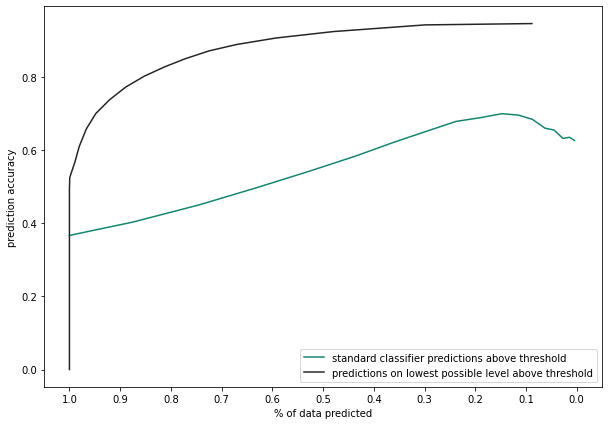

In [41]:
plot_baseline_vs_tf_hierarchy_metric_for_ckpt("Baseline vs Hierarchy Acc","efficientnet-b0","FT-28-01-20-8","7800")

load metrics for ckpt: gs://ise-bucket/efficientnet/efficientnet-b0/FT-28-01-20-8/model.ckpt-7000
check for metrics in gs://ise-bucket/efficientnet/efficientnet-b0/FT-28-01-20-8 for ckpt num 7000


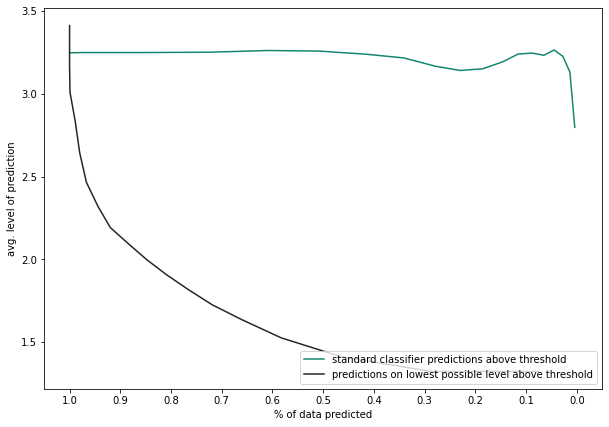

In [42]:
plot_baseline_vs_tf_avg_level_metric_for_ckpts("Baseline vs Hierarchy Level","efficientnet-b0","FT-28-01-20-8","7000")

load metrics for ckpt: gs://ise-bucket/efficientnet/efficientnet-b0/FT-28-01-20-8/model.ckpt-7800
check for metrics in gs://ise-bucket/efficientnet/efficientnet-b0/FT-28-01-20-8 for ckpt num 7800
load metrics for ckpt: gs://ise-bucket/efficientnet/efficientnet-b0/FT-02-02-20-4/model.ckpt-35000
check for metrics in gs://ise-bucket/efficientnet/efficientnet-b0/FT-02-02-20-4 for ckpt num 35000


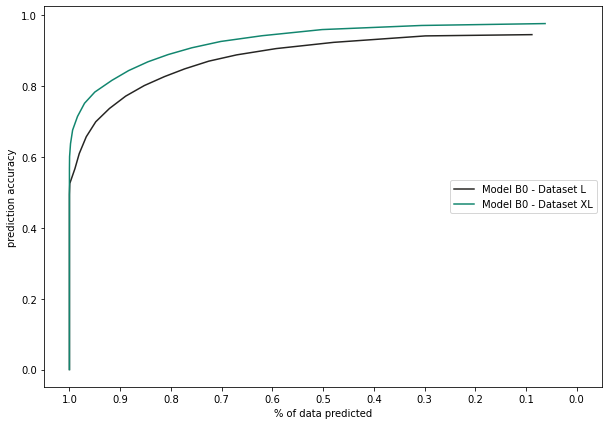

In [43]:
plot_hierarchy_metric_for_ckpts("Dataset L vs Dataset XL Hierarchy",[("efficientnet-b0","FT-28-01-20-8","7800", "Model B0 - Dataset L"),("efficientnet-b0","FT-02-02-20-4","35000", "Model B0 - Dataset XL")])

load metrics for ckpt: gs://ise-bucket/efficientnet/efficientnet-b0/FT-28-01-20-8/model.ckpt-7800
check for metrics in gs://ise-bucket/efficientnet/efficientnet-b0/FT-28-01-20-8 for ckpt num 7800
load metrics for ckpt: gs://ise-bucket/efficientnet/efficientnet-b0/FT-02-02-20-4/model.ckpt-35000
check for metrics in gs://ise-bucket/efficientnet/efficientnet-b0/FT-02-02-20-4 for ckpt num 35000


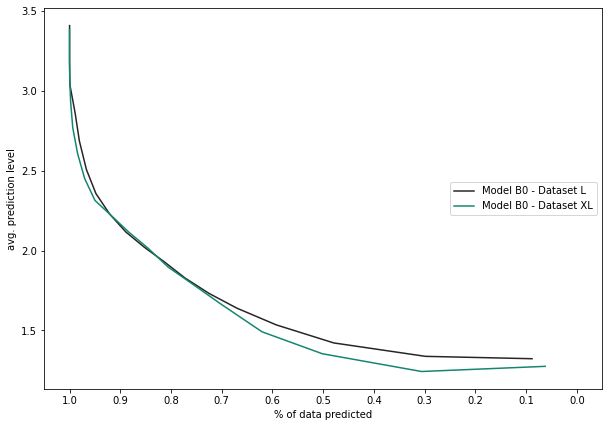

In [44]:
plot_avg_level_metric_for_ckpts("Dataset L vs Dataset XL Level",[("efficientnet-b0","FT-28-01-20-8","7800", "Model B0 - Dataset L"),("efficientnet-b0","FT-02-02-20-4","35000", "Model B0 - Dataset XL")])

load metrics for ckpt: gs://ise-bucket/efficientnet/efficientnet-b0/FT-28-01-20-8/model.ckpt-7800
check for metrics in gs://ise-bucket/efficientnet/efficientnet-b0/FT-28-01-20-8 for ckpt num 7800
load metrics for ckpt: gs://ise-bucket/efficientnet/efficientnet-b0/FT-30-01-20-2/model.ckpt-7000
check for metrics in gs://ise-bucket/efficientnet/efficientnet-b0/FT-30-01-20-2 for ckpt num 7000
load metrics for ckpt: gs://ise-bucket/efficientnet/efficientnet-b0/FT-02-02-20-5/model.ckpt-6800
check for metrics in gs://ise-bucket/efficientnet/efficientnet-b0/FT-02-02-20-5 for ckpt num 6800


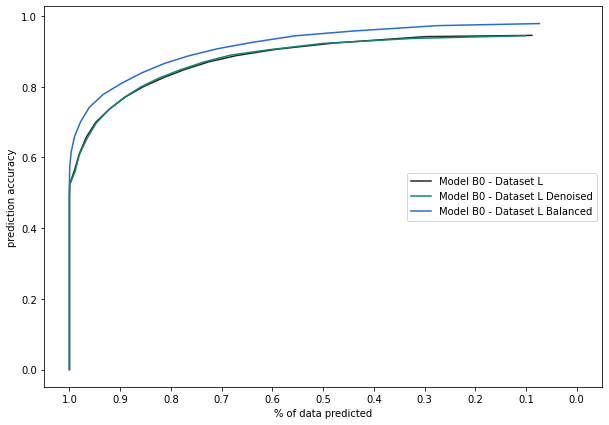

In [45]:
plot_hierarchy_metric_for_ckpts("Dataset Quality Hierarchy",[("efficientnet-b0","FT-28-01-20-8","7800", "Model B0 - Dataset L"),("efficientnet-b0","FT-30-01-20-2","7000", "Model B0 - Dataset L Denoised"),("efficientnet-b0","FT-02-02-20-5","6800", "Model B0 - Dataset L Balanced")])

load metrics for ckpt: gs://ise-bucket/efficientnet/efficientnet-b0/FT-28-01-20-8/model.ckpt-7800
check for metrics in gs://ise-bucket/efficientnet/efficientnet-b0/FT-28-01-20-8 for ckpt num 7800
load metrics for ckpt: gs://ise-bucket/efficientnet/efficientnet-b0/FT-30-01-20-2/model.ckpt-7000
check for metrics in gs://ise-bucket/efficientnet/efficientnet-b0/FT-30-01-20-2 for ckpt num 7000
load metrics for ckpt: gs://ise-bucket/efficientnet/efficientnet-b0/FT-02-02-20-5/model.ckpt-6800
check for metrics in gs://ise-bucket/efficientnet/efficientnet-b0/FT-02-02-20-5 for ckpt num 6800


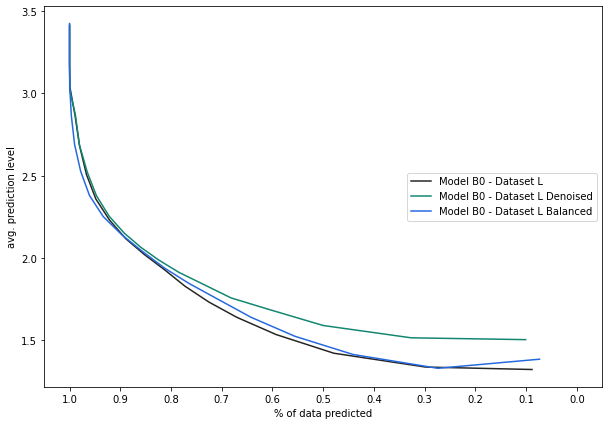

In [46]:
plot_avg_level_metric_for_ckpts("Dataset Quality Level",[("efficientnet-b0","FT-28-01-20-8","7800", "Model B0 - Dataset L"),("efficientnet-b0","FT-30-01-20-2","7000", "Model B0 - Dataset L Denoised"),("efficientnet-b0","FT-02-02-20-5","6800", "Model B0 - Dataset L Balanced")])

load metrics for ckpt: gs://ise-bucket/efficientnet/efficientnet-b0/FT-28-01-20-8/model.ckpt-7800
check for metrics in gs://ise-bucket/efficientnet/efficientnet-b0/FT-28-01-20-8 for ckpt num 7800
load metrics for ckpt: gs://ise-bucket/efficientnet/efficientnet-b0/FT-02-02-20-6-scratch/model.ckpt-29375
check for metrics in gs://ise-bucket/efficientnet/efficientnet-b0/FT-02-02-20-6-scratch for ckpt num 29375
load metrics for ckpt: gs://ise-bucket/efficientnet/efficientnet-b0/FT-02-02-20-10-warm/model.ckpt-6000
check for metrics in gs://ise-bucket/efficientnet/efficientnet-b0/FT-02-02-20-10-warm for ckpt num 6000


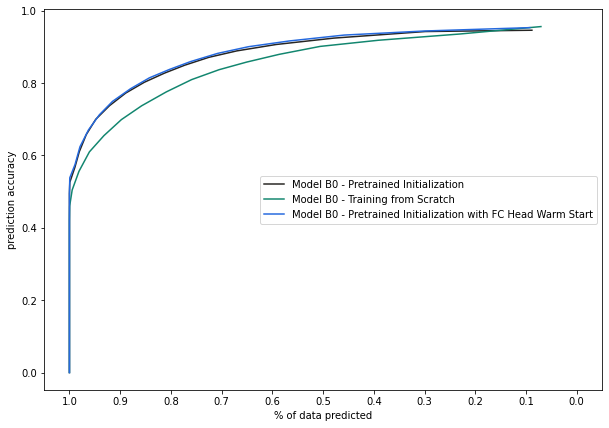

In [47]:
plot_hierarchy_metric_for_ckpts("Learning Strategies Hierarchy",[("efficientnet-b0","FT-28-01-20-8","7800", "Model B0 - Pretrained Initialization"),("efficientnet-b0","FT-02-02-20-6-scratch","29375", "Model B0 - Training from Scratch"),("efficientnet-b0","FT-02-02-20-10-warm","6000", "Model B0 - Pretrained Initialization with FC Head Warm Start")])

load metrics for ckpt: gs://ise-bucket/efficientnet/efficientnet-b0/FT-28-01-20-8/model.ckpt-7800
check for metrics in gs://ise-bucket/efficientnet/efficientnet-b0/FT-28-01-20-8 for ckpt num 7800
load metrics for ckpt: gs://ise-bucket/efficientnet/efficientnet-b0/FT-02-02-20-6-scratch/model.ckpt-29375
check for metrics in gs://ise-bucket/efficientnet/efficientnet-b0/FT-02-02-20-6-scratch for ckpt num 29375
load metrics for ckpt: gs://ise-bucket/efficientnet/efficientnet-b0/FT-02-02-20-10-warm/model.ckpt-6000
check for metrics in gs://ise-bucket/efficientnet/efficientnet-b0/FT-02-02-20-10-warm for ckpt num 6000


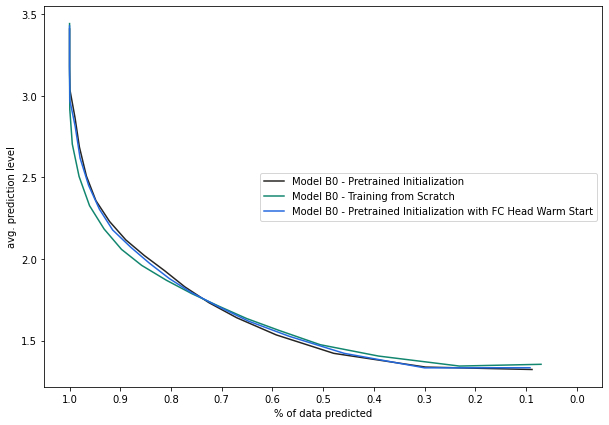

In [48]:
plot_avg_level_metric_for_ckpts("Learning Strategies Level",[("efficientnet-b0","FT-28-01-20-8","7800", "Model B0 - Pretrained Initialization"),("efficientnet-b0","FT-02-02-20-6-scratch","29375", "Model B0 - Training from Scratch"),("efficientnet-b0","FT-02-02-20-10-warm","6000", "Model B0 - Pretrained Initialization with FC Head Warm Start")])

#Predict single Image


functions to predict single image

In [0]:
import utils as ut
import preprocessing
from IPython import display

class EvalCkptDriver(ut.EvalCkptDriver):
  """A driver for running eval inference."""

  def build_model(self, features, is_training):
    """Build model using the model_name given through the command line."""
    model_builder = efficientnet_builder

    
    features -= tf.constant(
        model_builder.MEAN_RGB, shape=[1, 1, 3], dtype=features.dtype)
    features /= tf.constant(
        model_builder.STDDEV_RGB, shape=[1, 1, 3], dtype=features.dtype)
    
    output_layer, endpoints = model_builder.build_model(
        features,
        model_name=model_name,
        fine_tuning = True,
        pooled_features_only = False,
        features_only = False,
        training=is_training,
        model_dir=model_dir) #model_dir used for saving configs

      
    # new architecture

    def dense_kernel_initializer(shape, dtype=None, partition_info=None):
      del partition_info
      init_range = 1.0 / np.sqrt(shape[1])
      return tf.random_uniform(shape, -init_range, init_range, dtype=dtype)

    _fc = tf.layers.Dense(
            num_label_classes,
            kernel_initializer=dense_kernel_initializer,name = "ldense")
      
    logits = _fc(endpoints['global_pool'])

    probs = tf.nn.softmax(logits)
    probs = tf.squeeze(probs)

    return probs

  def get_preprocess_fn(self):
    """Build input dataset."""
    return preprocessing.preprocess_image

  def eval_example_images(self,
                          ckpt_dir,
                          image_files,
                          labels_map_reverse,
                          enable_ema=True,
                          export_ckpt=None):
    """Eval a list of example images.

    Args:
      ckpt_dir: str. Checkpoint directory path.
      image_files: List[str]. A list of image file paths.
      labels_map_file: str. The labels map file path.
      enable_ema: enable expotential moving average.
      export_ckpt: export ckpt folder.

    Returns:
      A tuple (pred_idx, and pred_prob), where pred_idx is the top 5 prediction
      index and pred_prob is the top 5 prediction probability.
    """
    classes = labels_map_reverse
    out_probs, pred_idx, pred_prob = self.run_inference(
        ckpt_dir, image_files, [0] * len(image_files), enable_ema, export_ckpt)
    for i in range(len(image_files)):
      print('predicted classes for image {}: '.format(image_files[i]))
      for j, idx in enumerate(pred_idx[i]):
        print('  -> top_{} ({:4.2f}%): {}  '.format(j, pred_prob[i][j] * 100,
                                                    classes[idx]))
    return out_probs, pred_idx, pred_prob

  def run_inference(self,
                    ckpt_dir,
                    image_files,
                    labels,
                    enable_ema=True,
                    export_ckpt=None):
    """Build and run inference on the target images and labels."""
    label_offset = 1 if self.include_background_label else 0
    with tf.Graph().as_default(), tf.Session() as sess:
      images, labels = self.build_dataset(image_files, labels, False)
      probs = self.build_model(images, is_training=False)
      if isinstance(probs, tuple):
        probs = probs[0]

      self.restore_model(sess, ckpt_dir, enable_ema, export_ckpt)

      prediction_idx = []
      prediction_prob = []
      for _ in range(len(image_files) // self.batch_size):
        out_probs = sess.run(probs)
        idx = np.argsort(out_probs)[::-1]
        prediction_idx.append(idx[:5] - label_offset)
        prediction_prob.append([out_probs[pid] for pid in idx[:5]])

      # Return the top 5 predictions (idx and prob) for each image.
      return out_probs, prediction_idx, prediction_prob



def get_eval_driver(model_name,image_size,num_classes,include_background_label=False):
  return EvalCkptDriver(
      model_name=model_name,
      batch_size=1,
      image_size=input_image_size,
      num_classes = num_label_classes,
      include_background_label=include_background_label)


predict single image

In [0]:
# Provide url to image to predict its rdf:type
!wget https://s.hs-data.com/picmon/e7/3dxW_7034Lh_l.jpg -O image_to_pred.jpeg

# Display image
image_file = 'image_to_pred.jpeg'
display.display(display.Image(image_file))

# Read Labels
df = pd.read_csv('gs://ise-bucket/efficientnet/configs/config_3/labels_map.csv',index_col=None)
labels_map_reverse = dict(zip(df.label_index, df.label))

# Set up Evaludation Driver
eval_driver = get_eval_driver(
      model_name=model_name,
      image_size=input_image_size,
      num_classes = num_label_classes,
      include_background_label=include_background_label)

# Predict
out_probs, pred_idx, pred_prob = eval_driver.eval_example_images(model_dir, [image_file], labels_map_reverse)
print("predicted classes for aggregated confidences:")
agg_conf_per_image_dict,top_pred_per_level_per_image = calc_agg_confs([{"probabilities":out_probs}])
agg_confs_and_labels = [(agg_conf_per_image_dict[0][label],all_labels[label]) for label in all_labels_index]
agg_confs_and_labels = sorted(agg_confs_and_labels, reverse=True, key=lambda x: x[0])
for j, prediction in enumerate(conf[:5]):
        print('  -> top_{} ({:4.2f}%): {}  '.format(j, prediction[0] * 100,
                                                    prediction[1]))